Running assumptions:
1. Given N number of shops
2. At each coordinate there will be a CustomerAgent. The customer will have a preference for a single shop based on distance (transportation costs) and price. 
3. The shop will adjust price and position so as to maximize profit. 

In [5]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid

from typing import Any

rng = np.random.default_rng(seed = 2000)

In [6]:
# Utils
def euclid_dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [7]:
class Shop(Agent):
    """
    Profit-maximizing firm (shop) will modify price \
    and location to compete for greater market share.
    """

    def __init__(self, color, unique_id, model):
        super().__init__(unique_id, model)
        self.price = 10
        self.color = color
        self.area_count = 0
        # cached results
        self.position_adj_cached = None
        self.price_adj_cached = None

    def __repr__(self):
        return f"Shop {self.unique_id}"

    def step(self):
        self.adjust_location()
        self.adjust_price()

    def advance(self):
        self.affect_location()
        self.affect_price()

    def adjust_location(self):
        # Save initial position
        initial_pos = self.pos

        # get all possible moves
        _possible_moves = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=True)

        # get a mapping of all possible moves to their potential areas/market shares
        _potential_areas = {}
        for move in _possible_moves:
            self.model.grid.move_agent(self, move)
            _potential_areas[move] = self.model.recalculate_areas()[self]

        # select and store the move with the highest potential area/market share
        _choice = max(_potential_areas, key=_potential_areas.get)
        self.position_adj_cached = _choice

        # pull back to initial position if affect is False
        self.model.grid.move_agent(self, initial_pos)

    def adjust_price(self):
        # Save initial price
        initial_price = self.price

        # Build the list of candidate prices
        _possible_prices = [self.price, self.price + 1, self.price - 1]
        # Pair each potential price change to its potential revenue
        _possible_revenues = {}
        for price in _possible_prices:
            self.price = price
            _possible_revenues[price] = self.model.recalculate_areas()[self] * price
        # Check if all potential revenue are 0
            # If so, decrease revenue by 1 and increase by 1
        if all(value==0 for value in _possible_revenues.values()) & (self.price > 1):
            self.price_adj_cached = self.price - 1
        # Otherwise, select the price that maximizes potential revenue
        else:
            self.price_adj_cached = max(_possible_revenues, key=_possible_revenues.get)
        # reset price
        self.price = initial_price

    def affect_location(self):
        self.model.grid.move_agent(self, self.position_adj_cached)

    def affect_price(self):
        self.price = self.price_adj_cached
    
    def potential_revenue(self):
        return self.price

In [8]:
class Hotelling(Model):
    """ 
    Model object manages key global variables such as \
    time, positions, and global parameters and variables.
    """
    def __init__(self, N, width, height, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(width, height, torus=False)

        # Get N colors for N agents
        n_colors = sns.color_palette("colorblind", n_colors=N, as_cmap=True,)

        # Create agents
        for i in range(N):
            a = Shop(color = n_colors[i], 
                     unique_id = i, 
                     model = self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = rng.integers(self.grid.width)
            y = rng.integers(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.initialize_data_collector(
            agent_reporters={"price":"price", 
                             "area":"area_count"}
        )


    def recalculate_areas(self):
        # initial areas dict is empty
        areas = {}

        # initialize shop dictionary
        for shop in self.schedule.agents:
            areas[shop] = 0

        # first, iterate through all cells, then, iterate through all shops
        for content, (x, y) in self.grid.coord_iter():
            _costs = {}
            for shop in self.schedule.agents:
                
                _costs[shop] = euclid_dist(x, y, shop.pos[0], shop.pos[1]) + shop.price
            _choice = min(_costs, key=_costs.get)
            areas[_choice] += 1
                
        return areas

    def step(self):
        # recalculate areas
        areas = self.recalculate_areas()

        for shop in self.schedule.agents:
            shop.area_count = areas[shop]

        # advance one tick
        self.schedule.step()

        # collect data
        self.datacollector.collect(self)

In [21]:
model = Hotelling(5, 25, 25)

In [26]:
for _ in range(25):
    model.step()

<Axes: xlabel='Step'>

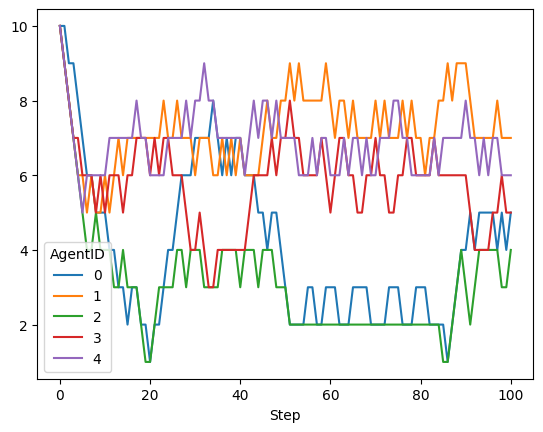

In [27]:
df = model.datacollector.get_agent_vars_dataframe() \
 .unstack(level=-1) 

df["price"].plot()